# Art Images Classification 


The work in this project is aimed at building the best predictive model in the context of a classification problem: specifically, multiple deep learning architectures using convolutional neural networks (CNN) are tested with the aim of classifying images of objects commonly found in museums, divided into 5 categories: *drawings, engravings, iconographies, paintings, and sculptures.*





The first step of this project consists of importing all the required and used libraries.

In [1]:
#!pip install comet_ml
#from comet_ml import Experiment
from google.colab import drive
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns
from PIL import Image
import numpy as np
import warnings
import random
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchsummary import summary
import torchvision.transforms as T
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, DataLoader
warnings.filterwarnings("ignore")
%matplotlib inline

Set the seed in order to make the code, model and results reproducible, and set the *device* variable in order to use the GPU to process the tensors and achieve significant speed increase during training.

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
seed = 1201

# Dataset

The dataset can be downloaded or added to a personal Google Drive account from [here](https://drive.google.com/drive/folders/1CAfhTejZeS2moWcM7CtxtvthnODQDXXu?usp=sharing).   
In the following code cell a Google Drive account that contains the dataset will be mounted, in order to access the dataset.


In [ ]:
experiment = Experiment(
    api_key="TvlvdIDbFURPToSaI49GYKB1P",
    project_name="nc-art",
    workspace="giuliasilvestro",
    log_code=True
)

In [ ]:
drive.mount('Drive', force_remount=True)
data_dir = 'Drive/MyDrive/art'
labels_list = sorted(list(os.listdir(data_dir)))

The dataset used in this project is a collection of different types of  artworks.

The main folder contains 5 sub-folders, one for each class, and each class contains a different number of images of different sizes.  

The total number of images is 8685, 108 of which were corrupted files that could not be read, and consequently were discarded.


In [ ]:
# Function that plots an histogram of the number of images in the different classes:

def files_per_directory(base_dir, categories):
    files_per_dir = []
    for category in categories:
        files = os.listdir(os.path.join(base_dir, category))
        files_per_dir.append(len(files))    
    plt.bar([x for x in range(len(files_per_dir))],
            files_per_dir, tick_label=categories)
    xlocs, xlabs = plt.xticks()
    xlocs=[i for i in range(0,5)]
    for i, v in enumerate(files_per_dir):
      plt.text(xlocs[i] , v , str(v), horizontalalignment="center")
    plt.show()

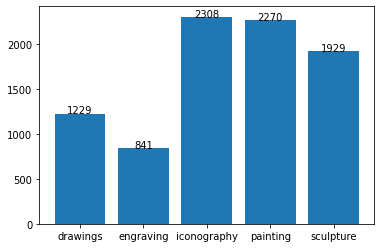

In [ ]:
files_per_directory(data_dir, labels_list)

The final total number of images is 8577. The number of images per class is:

*   **Drawing**: 1229
*   **Engraving**: 841
*   **Iconography**: 2308
*   **Painting**: 2270
*   **Sculpture**: 1929    

As we can observe the dataset is fairly balanced, except for the category *engraving* that has a lower number of images. Particular attention will be given to the results of the models regarding this class in order to evaluate if some balancing is needed.


An art Dataset class was created in order to store the samples and their corresponding labels from the folders and create a Dataset object that will be passed to the DataLoader which wraps an iterable around the Dataset to enable easy access to the batches and the samples.

In [4]:
class art(Dataset):
  def __init__(self, dset_dir, transforms=T.Compose([])):
    self.dset_dir = Path(dset_dir)
    self.transforms = transforms
    self.files = []
    folders = sorted(os.listdir(self.dset_dir))
    for folder in folders:
      class_idx = folders.index(folder)
      folder_dir = self.dset_dir/folder
      files = os.listdir(folder_dir)
      self.files += [{"file": folder_dir/x, "class": class_idx} for x in files]

  def __len__(self):
    return len(self.files)

  def __getitem__(self, i):
    item = self.files[i]
    file = item['file']
    class_idx = torch.tensor(item['class'])
    img = Image.open(file).convert("RGB")
    img = self.transforms(img)
    return img, class_idx

We can visualize some of the different images, randomly chosen from the dataset:

In [ ]:
# Define a function to plot images from the dataset.

def plot_images(data_pl):
    fig = plt.figure(1, (14, 9))
    k=0
    randomlist = random.sample(range(1, 8576), 28)
    for y in randomlist:
            px = data_pl[y][0].squeeze(0)
            px = px.permute(1,2,0)
            k += 1
            ax = plt.subplot(4, 7, k)
            px = np.array(px)
            ax.imshow(px,interpolation='nearest') # ((image * std) + mean) because it was normalized
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_title(labels_list[int(data_pl[y][1])])
            plt.tight_layout()
    return

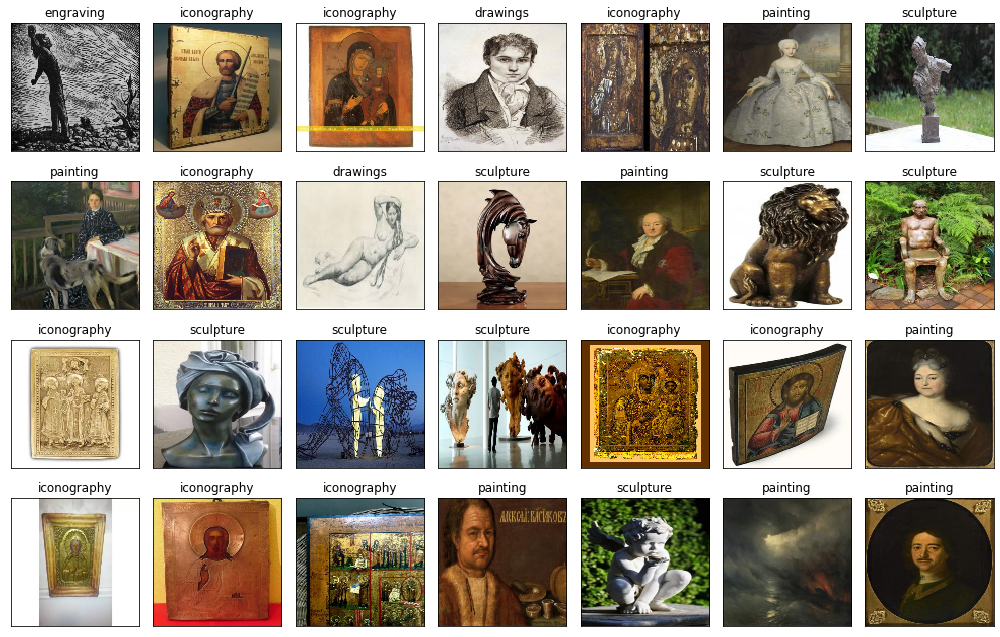

In [ ]:
plot_images(art(data_dir, transforms=T.Compose([T.ToTensor(),T.Resize((128,128))])))

We can also evaluate the distribution of the aspect ratio of the images in the dataset:

In [ ]:
# Define a function to plot the aspect ratio of the images from the dataset.

def plot_aspect_ratio(data_pl):
    aspect_ratios = []
    for y in data_pl:
      aspect_ratios.append(round(y[0][0].size()[1]/y[0][0].size()[0],2))
    sns.displot(aspect_ratios, bins=20, kde=True)
    return 

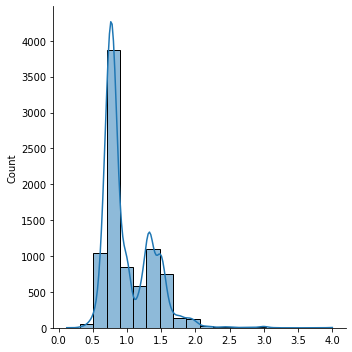

In [ ]:
plot_aspect_ratio(art(data_dir, transforms=T.Compose([T.ToTensor()])))

We can observe a lightly bimodal distribution, although  most of the images are in the aspect ratio  range of (0.5 - 1.6).

As a well performing classifier has to be invariant to a wide variety of transformations, before being fed to the network, the images go through a **Data Augmentation** process that consists in synthesizing datasimulating plausible transformations.

In particular the following transformations are made:

*   *ColorJitter:* Randomly changes the brightness, contrast, saturation and hue of an image uniformly in the range of the value passed as argument (0.2 for brightness, contrast and saturation, 0.01 for hue).

*   *Resize:*  Resizes the input images to the same size of 32x32. This allows a consistent size of input and will speed the training process.

*   *RandomHorizontalFlip:* Horizontally flips the given image randomly with a given probability of 0.45.

*   *RandomHorizontalFlip:* Vertically flips the given image randomly with a given probability of 0.45.

*   *Normalize:* Normalizes a tensor image with mean 0.5 and standard deviation 0.5, which means that all pixels values will be in the range [-1,1]. This will make convergence faster while training the network. 







In [5]:
transforms = T.Compose([
        T.ToTensor(),
        T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.01),
        T.Resize((32,32)),
        T.RandomHorizontalFlip(p=0.45),
        T.RandomVerticalFlip(p=0.45),
        T.Normalize(0.5, 0.5)
    ])

In [6]:
data = art(data_dir, transforms=transforms)

The dataset was also divided in three subsets following a 60-20-20 splitting rule:



*   **Training Set: 60%.**    Will be used to train the model.
*   **Validation Set: 20%.**  Will be used to fine-tune the hyperparameters.
*   **Test Set: 20%.**       Will be used once for each model and to compare the models in order to chose chose the best final one.




In [7]:
torch.manual_seed(seed)
np.random.seed(seed)
train_dset, validation_dset, test_dset = torch.utils.data.random_split(data, [5149, 1714, 1714])

Each image is represented as a Pytorch tensor hat has shape:

In [ ]:
input,_ = train_dset[0]
print(input.shape)

torch.Size([3, 32, 32])


where 3 represents the 3 color channels R, G, B, and 32, 32 represent the hight and width of the resized image.

We can now define the DataLoaders for each dataset and we set a batch size of 128.
Different batch sizes were tried out but, with the final chosen model a batch size of 128 gave the best results in terms of loss, accuracy, and computing time.

In [8]:
batch_size = 128

In [9]:
train_loader = DataLoader(train_dset, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=2)
validation_loader = DataLoader(validation_dset, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=2)
test_loader = DataLoader(test_dset, batch_size=1, shuffle=False, drop_last=False, num_workers=2)

# Chosen Model
The final best model (ArtNet) is composed of 4 convolutional layers, each followed by **max pooling** (except for the first layer), and 2 fully connected layers.

To each layer a **batch normalization** is applied and the chosen activation function is the **ReLu**, except for the last layer, to which a Softmax activation function is applied, as we are building a classifier.  



In particular:

* The **first convolutional layer**takes as input the 3x32x32 images and has 256x32x32  out channels.

* The **second convolutional layer** has 128x32x32 out channels.
A max pooling (128x16x16) is applied.

* The **third convolutional layer** has 64x16x16 out channels.
A max pooling (64x8x8) is applied.

* The **fourth convolutional layer** has 32x8x8 out channels.
An adaptive max pooling (32x2x2) is applied.

All of the convolutional layers are made of 3x3 kernels with padding = 1 and stride = 1.
The output of the convolutional layers is then flattened to a tensor of dimension 128 and fed to the fully connected layers:

* The **first fully connected layer** has an input size of 128 and output of 64.

* The  **second fully connected layer** is the output layer. It has an input size of 64 and output of 5, where each neuron represents one of the 5 classes to be predicted.

The network has a total of 404,263 trainable parameters.


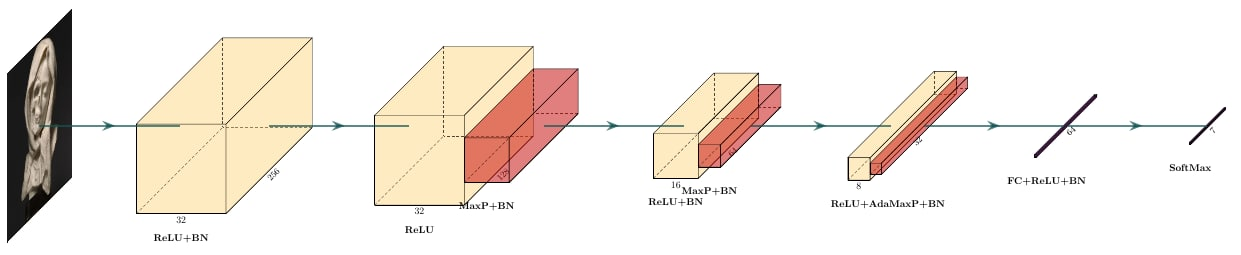

Image generated by using [this repository](https://github.com/HarisIqbal88/PlotNeuralNet).


In [ ]:
class artModel(nn.Module):
  #Constructor
  def __init__(self, in_size=3, out_size=5, use_norm=False):
    # Call parent contructor
    super().__init__()
    self.conv_layers = nn.Sequential(
      # Convolutional Layer 1
      nn.Conv2d(in_channels=in_size, out_channels=256, kernel_size=3, padding=1, stride=1),
      nn.ReLU(),
      nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
       
      # Convolutional Layer 2
      nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1, stride=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2),
      nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),

      # Convolutional Layer 3
      nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1, stride=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2),
      nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 
      # Convolutional Layer 4
      nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding=1, stride=1),
      nn.ReLU(),
      nn.AdaptiveMaxPool2d(output_size=2),
      nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
    )
    self.fc_layers = nn.Sequential(
        
      # Fully Connected layer 1
      nn.Linear(128, 64),
      nn.ReLU(),
      nn.BatchNorm1d(64),

      # Fully Connected layer 2 - Classifier
      nn.Linear(64, out_size),
    )
  # Forward
  def forward(self, x):
    b, _, _, _ = x.shape
    x = self.conv_layers(x)
    x = x.view(x.size(0), -1) 
    #print(x.size()) 
    output = self.fc_layers(x)
    return output.view(b, -1)

In [ ]:
net = artModel()

In [ ]:
summary(net.to(device),(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 256, 32, 32]           7,168
              ReLU-2          [-1, 256, 32, 32]               0
       BatchNorm2d-3          [-1, 256, 32, 32]             512
            Conv2d-4          [-1, 128, 32, 32]         295,040
              ReLU-5          [-1, 128, 32, 32]               0
         MaxPool2d-6          [-1, 128, 16, 16]               0
       BatchNorm2d-7          [-1, 128, 16, 16]             256
            Conv2d-8           [-1, 64, 16, 16]          73,792
              ReLU-9           [-1, 64, 16, 16]               0
        MaxPool2d-10             [-1, 64, 8, 8]               0
      BatchNorm2d-11             [-1, 64, 8, 8]             128
           Conv2d-12             [-1, 32, 8, 8]          18,464
             ReLU-13             [-1, 32, 8, 8]               0
AdaptiveMaxPool2d-14             [-1, 3

# Training

Two functions are defined for the training stage:  

The **train function** runs for 100 epochs as default, but the function is structured such that the execution of the cell can be manually interrupted at any epoch if necessary (eg. if it is obvious that the model is overfitting, the learning curves are diverging or it is converging too slowly.  

At the end of each epoch the accuracy on the validation set is compare with the validation accuracies of all the previous epochs and, if it is greater the **save_model function** is called, which saves the model in a file in order to test it, later, on the test set.

In [ ]:
def save_model(model_name):
  torch.save(net.state_dict(),'Drive/MyDrive/'+model_name )
  torch.save(optimizer.state_dict(),'Drive/MyDrive/OPTIMIZER'+model_name )
  

In [ ]:
def train(net, model_name, seed, loaders, optimizer, criterion, epochs=100, device=torch.device('cuda'), ):
    try:
        torch.manual_seed(seed)
        np.random.seed(seed)
        # Initialize history
        history_loss = {"train": [], "validation": []}
        history_accuracy = {"train": [], "validation": []}
        prev_val_acc = [0]
        # Process each epoch
        for epoch in range(epochs):
            # Initialize epoch variables
            sum_loss = {"train": 0, "validation": 0}
            sum_accuracy = {"train": 0, "validation": 0}
            # Process each split
            for split in ["train", "validation"]:
              # Process each batch 
              it = 0
              for (input, labels) in loaders[split]:
                    it += 1
                    # Move to CUDA
                    input = input.to(device)
                    labels = labels.to(device)
                    # Reset gradients
                    optimizer.zero_grad()
                    # Compute output
                    pred = net(input)
                    loss = criterion(pred, labels)
                    # Update loss
                    sum_loss[split] += loss.item()
                    # Check parameter update
                    if split == "train":
                        # Compute gradients
                        loss.backward()
                        # Optimize
                        optimizer.step()
                    # Compute accuracy
                    _,pred_labels = pred.max(1)
                    batch_accuracy = (pred_labels == labels).sum().item()/input.size(0)
                    # Update accuracy
                    sum_accuracy[split] += batch_accuracy
            # Compute epoch loss/accuracy
            epoch_loss = {split: sum_loss[split]/len(loaders[split]) for split in ["train", "validation"]}
            epoch_accuracy = {split: sum_accuracy[split]/len(loaders[split]) for split in ["train", "validation"]}
            # Update history
            for split in ["train", "validation"]:
                history_loss[split].append(epoch_loss[split])
                history_accuracy[split].append(epoch_accuracy[split])
            # Print info
            if epoch_accuracy['validation'] >=  max(prev_val_acc):
              save_model(model_name)
            prev_val_acc.append(epoch_accuracy['validation'])
            print(f"Epoch {epoch+1}:",
                  f"Tr_Loss={epoch_loss['train']:.4f},",
                  f"Tr_Acc={epoch_accuracy['train']:.4f},",
                  f"Val_Loss={epoch_loss['validation']:.4f},",
                  f"Val_Acc={epoch_accuracy['validation']:.4f},")
            #experiment.log_metric("Tr_Loss", epoch_loss['train'], step=epoch+1)
            #experiment.log_metric("Tr_Acc", epoch_accuracy['train'], step=epoch+1)
            #experiment.log_metric("Val_Loss", epoch_loss['validation'], step=epoch+1)
            #experiment.log_metric("Val_Acc", epoch_accuracy['validation'], step=epoch+1)

    except KeyboardInterrupt:
        print("Interrupted")
    finally:
        # Plot loss
        plt.title("Loss")
        for split in ["train", "validation"]:
            plt.plot(history_loss[split], label=split)
        plt.legend()
        plt.show()
        # Plot accuracy
        plt.title("Accuracy")
        for split in ["train", "validation"]:
            plt.plot(history_accuracy[split], label=split)
        plt.legend()
        plt.show()

Epoch 1: Tr_Loss=0.9528, Tr_Acc=0.6613, Val_Loss=0.8084, Val_Acc=0.7200,
Epoch 2: Tr_Loss=0.6889, Tr_Acc=0.7562, Val_Loss=0.6776, Val_Acc=0.7716,
Epoch 3: Tr_Loss=0.6223, Tr_Acc=0.7789, Val_Loss=0.6214, Val_Acc=0.7788,
Epoch 4: Tr_Loss=0.5537, Tr_Acc=0.8080, Val_Loss=0.5846, Val_Acc=0.7867,
Epoch 5: Tr_Loss=0.5217, Tr_Acc=0.8105, Val_Loss=0.5329, Val_Acc=0.8113,
Epoch 6: Tr_Loss=0.4874, Tr_Acc=0.8240, Val_Loss=0.4848, Val_Acc=0.8311,
Epoch 7: Tr_Loss=0.4580, Tr_Acc=0.8387, Val_Loss=0.4640, Val_Acc=0.8353,
Epoch 8: Tr_Loss=0.4228, Tr_Acc=0.8512, Val_Loss=0.4726, Val_Acc=0.8251,
Epoch 9: Tr_Loss=0.4088, Tr_Acc=0.8500, Val_Loss=0.4707, Val_Acc=0.8329,
Epoch 10: Tr_Loss=0.3882, Tr_Acc=0.8602, Val_Loss=0.4615, Val_Acc=0.8269,
Epoch 11: Tr_Loss=0.3692, Tr_Acc=0.8631, Val_Loss=0.4698, Val_Acc=0.8305,
Epoch 12: Tr_Loss=0.3504, Tr_Acc=0.8699, Val_Loss=0.4506, Val_Acc=0.8383,
Epoch 13: Tr_Loss=0.3290, Tr_Acc=0.8773, Val_Loss=0.4375, Val_Acc=0.8425,
Epoch 14: Tr_Loss=0.3190, Tr_Acc=0.8852, Val_Lo

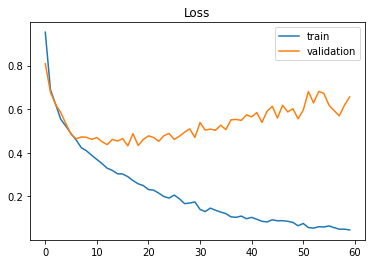

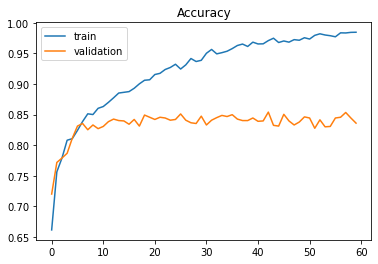

In [ ]:
torch.manual_seed(seed)
np.random.seed(seed)
net = artModel()
net = net.to(device)
learning_rate = 0.0008
optimizer = optim.Adam(net.parameters(), lr = learning_rate, amsgrad = True)
criterion = nn.CrossEntropyLoss()

# Define dictionary of loaders
loaders = {"train": train_loader,
           "validation": validation_loader}
import warnings
warnings.filterwarnings("ignore")
model_name = 'model_ART10'
train(net, model_name, seed, loaders, optimizer, criterion, epochs=60, device=device)

The model at epoch 43 is the final chosen model, as it has the highes accuracy on the validation set.

# Evaluation

In [14]:
def eval_model(model, data_loader):
    model.eval() # Set model to eval model
    torch.manual_seed(921)
    true_preds, num_preds = 0., 0.

    with torch.no_grad(): # Deactivate gradients for the following code
        y_true = []
        y_predicted = []

        for data_inputs, data_labels in data_loader:
          
            # Determine prediction of model on dev set
            data_inputs = data_inputs.to(device)
            data_labels = data_labels.to(device)
            preds = model(data_inputs)
            preds = preds.squeeze(dim=1)
            preds = torch.softmax(preds, 1) # Softmax to map predictions between 0 and 1
            pred_labels = torch.argmax(preds)

            y_true.append(int(data_labels))
            y_predicted.append(int(pred_labels)) 

            # Keep records of predictions for the accuracy metric (true_preds=TP+TN, num_preds=TP+TN+FP+FN)
            true_preds += (pred_labels == data_labels).sum()
            num_preds += data_labels.shape[0]

    y_true = np.array(y_true)
    y_predicted = np.array(y_predicted)
    #experiment.log_confusion_matrix(y_true, y_predicted, labels = labels_list)    

    acc = true_preds / num_preds
    #experiment.log_metric("Test_Acc", acc, step=0)
    print("Accuracy of the model: %f%%" % (100.0*acc))
    return y_true, y_predicted

In [ ]:
net1 = artModel()
net1.load_state_dict(torch.load('Drive/MyDrive/model_ART10'))
net1 = net1.to(device)
y_true, y_predicted = eval_model(net1, test_loader)

Accuracy of the model: 84.364059%


# Ablation Study

An ablation study studies the performance of a neural network by removing certain components, to understand the contribution of the component to the overall model. 

As the chosen model holds 4 convolutional layers plus 1 fully connected and one classification layer, the performance of the following models is evaluated: 
* 1st Conv layer + FC + Classifier.
* 1st + 2nd Conv layers + FC + Classifier.
* 1st + 2nd + 3rd Conv layers + FC + Classifier.
* 1st + 2nd + 3rd + 4th Conv layers + FC + Classifier (ArtNet).


### 1st Conv layer + FC + Classifier:


Define the model:

In [15]:
class artModel(nn.Module):
  #Constructor
  def __init__(self, in_size=3, out_size=5, use_norm=False):
    # Call parent contructor
    super().__init__()
    self.conv_layers = nn.Sequential(
      # Convolutional Layer 1
      nn.Conv2d(in_channels=in_size, out_channels=256, kernel_size=3, padding=1, stride=1),
      nn.ReLU(),
      nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    self.fc_layers = nn.Sequential(
        
      # Fully Connected layer 1
      nn.Linear(262144, 64),
      nn.ReLU(),
      nn.BatchNorm1d(64),

      # Fully Connected layer 2 - Classifier
      nn.Linear(64, out_size),
    )
  # Forward
  def forward(self, x):
    b, _, _, _ = x.shape
    x = self.conv_layers(x)
    x = x.view(x.size(0), -1) 
    output = self.fc_layers(x)
    return output.view(b, -1)

Train:

Epoch 1: Tr_Loss=1.0691, Tr_Acc=0.5809, Val_Loss=0.9911, Val_Acc=0.6310,
Epoch 2: Tr_Loss=0.9077, Tr_Acc=0.6707, Val_Loss=0.8791, Val_Acc=0.6851,
Epoch 3: Tr_Loss=0.8000, Tr_Acc=0.7188, Val_Loss=0.7800, Val_Acc=0.7169,
Epoch 4: Tr_Loss=0.7118, Tr_Acc=0.7592, Val_Loss=0.7071, Val_Acc=0.7476,
Epoch 5: Tr_Loss=0.6289, Tr_Acc=0.7773, Val_Loss=0.6750, Val_Acc=0.7626,
Epoch 6: Tr_Loss=0.5513, Tr_Acc=0.8078, Val_Loss=0.6148, Val_Acc=0.7837,
Epoch 7: Tr_Loss=0.5267, Tr_Acc=0.8176, Val_Loss=0.6049, Val_Acc=0.7891,
Epoch 8: Tr_Loss=0.4452, Tr_Acc=0.8523, Val_Loss=0.5877, Val_Acc=0.7945,
Epoch 9: Tr_Loss=0.3982, Tr_Acc=0.8609, Val_Loss=0.5718, Val_Acc=0.7903,
Epoch 10: Tr_Loss=0.3841, Tr_Acc=0.8699, Val_Loss=0.5920, Val_Acc=0.7794,
Epoch 11: Tr_Loss=0.3317, Tr_Acc=0.8867, Val_Loss=0.5546, Val_Acc=0.8089,
Epoch 12: Tr_Loss=0.3037, Tr_Acc=0.9025, Val_Loss=0.5544, Val_Acc=0.8083,
Epoch 13: Tr_Loss=0.2690, Tr_Acc=0.9164, Val_Loss=0.5542, Val_Acc=0.8035,
Epoch 14: Tr_Loss=0.2439, Tr_Acc=0.9242, Val_Lo

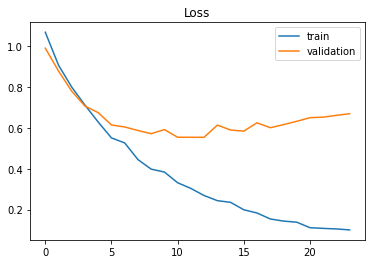

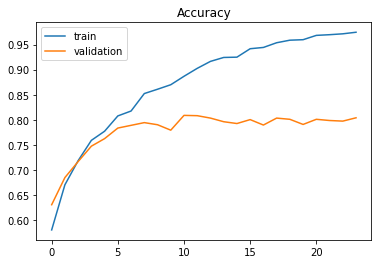

In [ ]:
torch.manual_seed(seed)
np.random.seed(seed)
net = artModel()
net = net.to(device)
learning_rate = 0.0008
optimizer = optim.Adam(net.parameters(), lr = learning_rate, amsgrad = True)

criterion = nn.CrossEntropyLoss()

# Define dictionary of loaders
loaders = {"train": train_loader,
           "validation": validation_loader}

model_name = 'model_ART_abl1_3'
train(net, model_name, seed, loaders, optimizer, criterion, epochs=36, device=device)

Evaluate:

In [16]:
net1 = artModel()
net1.load_state_dict(torch.load('Drive/MyDrive/model_ART_abl1_3'))
net1 = net1.to(device)
y_true, y_predicted = eval_model(net1, test_loader)

Accuracy of the model: 78.471413%


### 1st + 2nd Conv layers + FC + Classifier:


Define the model:

In [ ]:
class artModel(nn.Module):
  #Constructor
  def __init__(self, in_size=3, out_size=5, use_norm=False):
    # Call parent contructor
    super().__init__()
    self.conv_layers = nn.Sequential(
      # Convolutional Layer 1
      nn.Conv2d(in_channels=in_size, out_channels=256, kernel_size=3, padding=1, stride=1),
      nn.ReLU(),
      nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
       
      # Convolutional Layer 2
      nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1, stride=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2),
      nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),

    )
    self.fc_layers = nn.Sequential(
        
      # Fully Connected layer 1
      nn.Linear(32768, 64),
      nn.ReLU(),
      nn.BatchNorm1d(64),

      # Fully Connected layer 2 - Classifier
      nn.Linear(64, out_size),
    )
  # Forward
  def forward(self, x):
    b, _, _, _ = x.shape
    x = self.conv_layers(x)
    x = x.view(x.size(0), -1) 
    output = self.fc_layers(x)
    return output.view(b, -1)

Train:

Epoch 1: Tr_Loss=0.9156, Tr_Acc=0.6668, Val_Loss=0.7852, Val_Acc=0.7163,
Epoch 2: Tr_Loss=0.6811, Tr_Acc=0.7564, Val_Loss=0.6758, Val_Acc=0.7572,
Epoch 3: Tr_Loss=0.5926, Tr_Acc=0.7885, Val_Loss=0.5830, Val_Acc=0.7951,
Epoch 4: Tr_Loss=0.5380, Tr_Acc=0.8111, Val_Loss=0.5522, Val_Acc=0.8053,
Epoch 5: Tr_Loss=0.4811, Tr_Acc=0.8264, Val_Loss=0.5098, Val_Acc=0.8257,
Epoch 6: Tr_Loss=0.4327, Tr_Acc=0.8428, Val_Loss=0.4850, Val_Acc=0.8317,
Epoch 7: Tr_Loss=0.4008, Tr_Acc=0.8574, Val_Loss=0.4725, Val_Acc=0.8293,
Epoch 8: Tr_Loss=0.3490, Tr_Acc=0.8787, Val_Loss=0.4730, Val_Acc=0.8329,
Epoch 9: Tr_Loss=0.3159, Tr_Acc=0.8867, Val_Loss=0.4732, Val_Acc=0.8251,
Epoch 10: Tr_Loss=0.2976, Tr_Acc=0.8971, Val_Loss=0.4603, Val_Acc=0.8359,
Epoch 11: Tr_Loss=0.2480, Tr_Acc=0.9145, Val_Loss=0.4742, Val_Acc=0.8347,
Epoch 12: Tr_Loss=0.2301, Tr_Acc=0.9242, Val_Loss=0.4737, Val_Acc=0.8377,
Epoch 13: Tr_Loss=0.1931, Tr_Acc=0.9418, Val_Loss=0.4646, Val_Acc=0.8389,
Epoch 14: Tr_Loss=0.1670, Tr_Acc=0.9482, Val_Lo

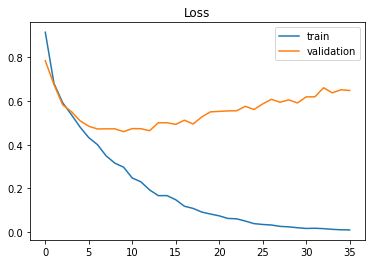

KeyboardInterrupt


KeyboardInterrupt: ignored

In [ ]:
torch.manual_seed(seed)
np.random.seed(seed)
net = artModel()
net = net.to(device)
learning_rate = 0.0008
optimizer = optim.Adam(net.parameters(), lr = learning_rate, amsgrad = True)

criterion = nn.CrossEntropyLoss()

# Define dictionary of loaders
loaders = {"train": train_loader,
           "validation": validation_loader}
import warnings
warnings.filterwarnings("ignore")
model_name = 'model_ART_abl2_2'
train(net, model_name, seed, loaders, optimizer, criterion, epochs=44, device=device)

Evaluate:

In [ ]:
net1 = artModel()
net1.load_state_dict(torch.load('Drive/MyDrive/model_ART_abl2_2'))
net1 = net1.to(device)
y_true, y_predicted = eval_model(net1, test_loader)

Accuracy of the model: 83.838974%


### 1st + 2nd + 3rd Conv layers + FC + Classifier:


Define the model:

In [ ]:
class artModel(nn.Module):
  #Constructor
  def __init__(self, in_size=3, out_size=5, use_norm=False):
    # Call parent contructor
    super().__init__()
    self.conv_layers = nn.Sequential(
      # Convolutional Layer 1
      nn.Conv2d(in_channels=in_size, out_channels=256, kernel_size=3, padding=1, stride=1),
      nn.ReLU(),
      nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
       
      # Convolutional Layer 2
      nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1, stride=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2),
      nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),

      # Convolutional Layer 3
      nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1, stride=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2),
      nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
    )
    self.fc_layers = nn.Sequential(
        
      # Fully Connected layer 1
      nn.Linear(4096, 64),
      nn.ReLU(),
      nn.BatchNorm1d(64),

      # Fully Connected layer 2
      nn.Linear(64, out_size),
    )
  # Forward
  def forward(self, x):
    b, _, _, _ = x.shape
    x = self.conv_layers(x)
    x = x.view(x.size(0), -1) 
    #print(x.size()) 
    output = self.fc_layers(x)
    return output.view(b, -1)

Train:

Epoch 1: Tr_Loss=0.8684, Tr_Acc=0.6918, Val_Loss=0.7515, Val_Acc=0.7416,
Epoch 2: Tr_Loss=0.6459, Tr_Acc=0.7717, Val_Loss=0.6372, Val_Acc=0.7764,
Epoch 3: Tr_Loss=0.5724, Tr_Acc=0.7963, Val_Loss=0.5899, Val_Acc=0.7903,
Epoch 4: Tr_Loss=0.5125, Tr_Acc=0.8187, Val_Loss=0.5241, Val_Acc=0.8071,
Epoch 5: Tr_Loss=0.4774, Tr_Acc=0.8199, Val_Loss=0.4793, Val_Acc=0.8347,
Epoch 6: Tr_Loss=0.4243, Tr_Acc=0.8424, Val_Loss=0.4716, Val_Acc=0.8377,
Epoch 7: Tr_Loss=0.4057, Tr_Acc=0.8543, Val_Loss=0.4621, Val_Acc=0.8371,
Epoch 8: Tr_Loss=0.3660, Tr_Acc=0.8689, Val_Loss=0.4724, Val_Acc=0.8365,
Epoch 9: Tr_Loss=0.3355, Tr_Acc=0.8744, Val_Loss=0.4778, Val_Acc=0.8341,
Epoch 10: Tr_Loss=0.3145, Tr_Acc=0.8814, Val_Loss=0.4510, Val_Acc=0.8353,
Epoch 11: Tr_Loss=0.2810, Tr_Acc=0.8979, Val_Loss=0.4624, Val_Acc=0.8311,
Epoch 12: Tr_Loss=0.2781, Tr_Acc=0.8975, Val_Loss=0.4475, Val_Acc=0.8413,
Epoch 13: Tr_Loss=0.2356, Tr_Acc=0.9137, Val_Loss=0.4346, Val_Acc=0.8546,
Epoch 14: Tr_Loss=0.2194, Tr_Acc=0.9240, Val_Lo

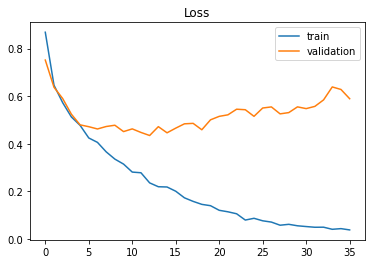

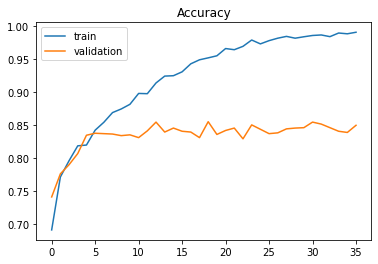

In [ ]:
torch.manual_seed(seed)
np.random.seed(seed)
net = artModel()
net = net.to(device)
learning_rate = 0.0008
optimizer = optim.Adam(net.parameters(), lr = learning_rate, amsgrad = True)

criterion = nn.CrossEntropyLoss()

# Define dictionary of loaders
loaders = {"train": train_loader,
           "validation": validation_loader}

model_name = 'model_ART_abl3_2'
train(net, model_name, seed, loaders, optimizer, criterion, epochs=44, device=device)

Evaluate:

In [ ]:
net1 = artModel()
net1.load_state_dict(torch.load('Drive/MyDrive/model_ART_abl3_2'))
net1 = net1.to(device)
y_true, y_predicted = eval_model(net1, test_loader)

Accuracy of the model: 82.905487%


# Comments on Results


From the ablation study we notice that each decrease in the number of convolutional layers, leads to a the model shows a noticeable
decrease in performance.  
In particular:


*   Adding an additional convolutional layer shows a drop of around **2%** in the test accuracy.
*   Removing the last convolutional layers shows a drop of around **2%** in the test accuracy.
*   Removing the last two convolutional layers shows a drop of around **4%** in the test accuracy.
*   Removing the last three convolutional layers shows a drop of around **7.1%** in the test accuracy.

Therefore we conclude that adding a convolutional layer to the model, as well as decreasing its depth doesn't lead to an increase in performance.


We now analyze the confusion matrix of the chosen model:

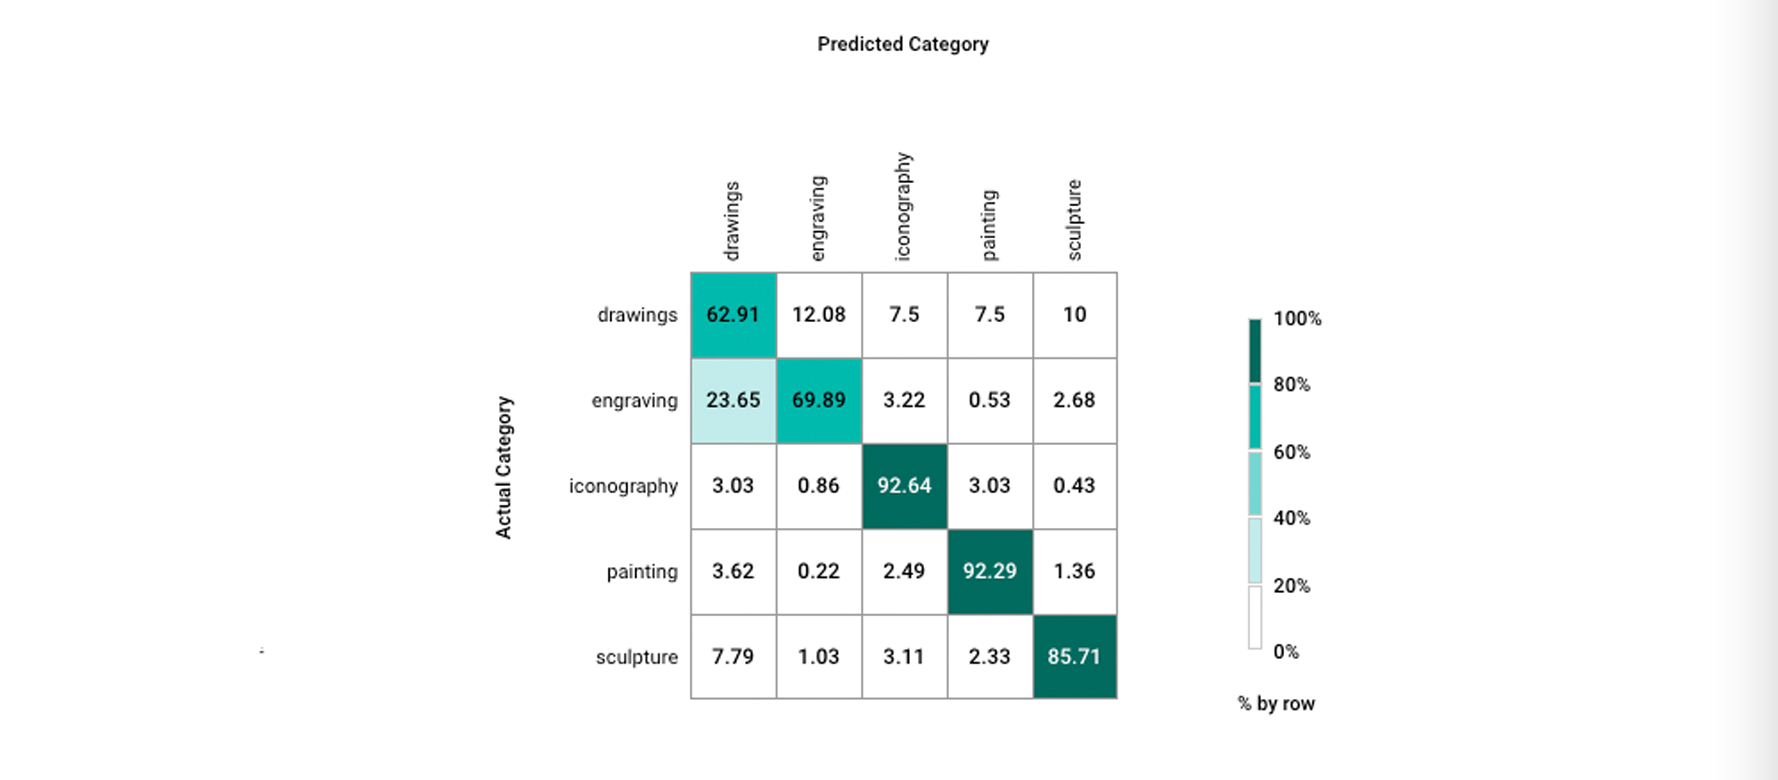

As it is apparent from the matrix, the most correctly classified images were those of icono-graphies  (92.6%),  paintings  (92.2%)  and  sculptures  (85.7%).  

Drawings  was  the  category that had the lowest percentage of correct predictions (63%), with misclassifications almost uniformally distributed across the other classes even though 12% of observations were incorrectly classified as engravings and 10% as sculptures.  

Engravings was the category that had the least observations (841 vs Drawing:  1229, Iconography:  2308, Painting:  2270, Sculp-ture:  1929).  
However, 70% of observations were correctly classified and almost all of the missclassifications (23.6%) were incorrectly classified as drawings.  

From these observations we can conclude that the category of drawings is the most challenging for the model.